In [1]:
import torch
import torch.nn as nn
import torchvision
from norse.torch import PoissonEncoder
from norse.torch.module.lif import LIFCell, LIFParameters
from ConductanceBasedLIF import (
    CobaLIFCell,
    CobaLIFParameters,
    CobaLIFFeedForwardState,
    coba_lif_feed_forward_step,
)
from DiehlAndCook2015 import (
    DiehlLIFCell,
    DiehlLIFRecurrentCell,
    DiehlLIFParameters,
    DiehlLIFState,
    DiehlLIFFeedForwardState,
    diehl_lif_step,
    diehl_lif_feed_forward_step,
)
import matplotlib.pyplot as plt
from typing import Optional, NamedTuple, Tuple
from norse.torch.functional.threshold import threshold

In [2]:
p = CobaLIFParameters(
    tau_syn_exc_inv=1 / 20e-3,
    tau_syn_inh_inv=1 / 20e-3,
    c_m_inv=torch.as_tensor(1 / 20e-3),
    g_l=torch.as_tensor(1.0),
    e_rev_E=0.0,
    e_rev_I=-85.0,
    v_thresh=-40.0,
    v_reset=-45.0,
    v_rest=-60.0,
)

Text(0, 0.5, 'Voltage')

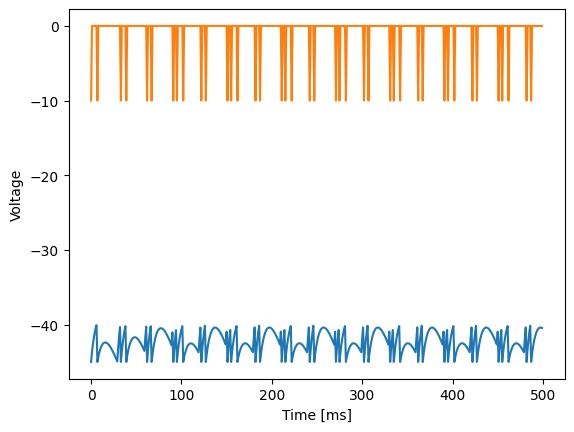

In [3]:
data = torch.zeros(500)
data[::30] = 1.0

state = CobaLIFFeedForwardState(
    v=torch.zeros(1),
    g_e=torch.zeros(1),
    g_i=torch.zeros(1),
)

volt = []
output = []
for i in range(len(data)):
    z, state = coba_lif_feed_forward_step(data[i], state, p=p)
    volt.append(state.v.detach())
    output.append(z * -10)

fig, ax = plt.subplots()
ax.plot(volt)
ax.plot(output)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Voltage")

In [4]:
p = DiehlLIFParameters(
    tau_syn_exc_inv=1 / 20e-3,
    tau_syn_inh_inv=1 / 20e-3,
    tau_v_thresh_inv=1 / 1e4,
    c_m_inv=torch.as_tensor(1 / 100e-3),
    g_l=torch.as_tensor(1.0),
    e_rev_E=0.0,
    e_rev_I=-100.0,
    v_thresh=-52.0,
    v_reset=-65.0,
    v_rest=-65.0,
    v_thresh_plus=0.05,
    v_thresh_max=35.0,
)

Text(0, 0.5, 'Voltage')

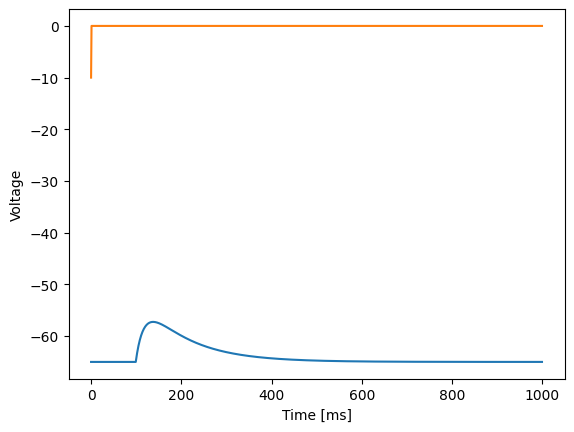

In [5]:
data = torch.zeros(1000)
# data[::100] = 1.0
data[100] = 1

state = DiehlLIFFeedForwardState(
    v=torch.zeros(1),
    g_e=torch.zeros(1),
    g_i=torch.zeros(1),
    delta_v_thresh=torch.zeros(1),
)

volt = []
output = []
for i in range(len(data)):
    z, state = diehl_lif_feed_forward_step(data[i], state, p=p)
    volt.append(state.v.detach())
    output.append(z * -10)


fig, ax = plt.subplots()
ax.plot(volt)
ax.plot(output)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Voltage")

In [6]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)
TIME = 300
encoder = PoissonEncoder(TIME, f_max=64)
x = encoder(train_data[0][0])

In [10]:
lif = DiehlLIFRecurrentCell(
    28 * 28,
    1,
    p=DiehlLIFParameters(
        tau_syn_exc_inv=1 / 20e-3,
        tau_syn_inh_inv=1 / 20e-3,
        tau_v_thresh_inv=1 / 1e4,
        c_m_inv=torch.as_tensor(1 / 100e-3),
        g_l=torch.as_tensor(1.0),
        e_rev_E=0.0,
        e_rev_I=-100.0,
        v_thresh=-52.0,
        v_reset=-65.0,
        v_rest=-65.0,
        v_thresh_plus=0.05,
        v_thresh_max=35.0,
    ),
)
nn.init.uniform_(lif.input_weights.data, a=0.0, b=1e-3)
nn.init.constant_(lif.recurrent_weights.data, 0.0)

print(lif.input_weights)
print(lif.recurrent_weights)

Parameter containing:
tensor([[1.0742e-05, 3.4116e-04, 7.7824e-05, 4.8218e-04, 1.3152e-04, 2.8867e-04,
         1.0844e-04, 3.0678e-04, 7.2268e-04, 5.4312e-04, 3.3449e-04, 6.9171e-04,
         9.2135e-04, 2.9453e-04, 8.9784e-05, 9.9174e-04, 5.4655e-04, 4.6120e-04,
         5.0246e-04, 4.7283e-04, 5.2251e-04, 6.2383e-04, 1.4183e-04, 1.7215e-04,
         2.4436e-04, 7.1233e-04, 9.8359e-04, 7.2088e-04, 3.9646e-04, 9.0804e-04,
         3.4817e-04, 5.6476e-04, 8.3091e-04, 9.9771e-04, 9.8154e-04, 5.7444e-04,
         8.3795e-05, 1.2289e-04, 7.3851e-04, 4.0653e-04, 7.2740e-06, 1.1795e-05,
         8.7178e-04, 9.3807e-05, 9.4900e-05, 3.6230e-04, 8.0271e-04, 5.1571e-04,
         1.0471e-04, 6.4565e-04, 5.9609e-04, 5.7395e-04, 9.9674e-04, 8.1403e-04,
         2.5969e-04, 2.4502e-04, 3.3818e-04, 2.9295e-04, 1.0205e-04, 4.5839e-04,
         8.0123e-05, 6.7944e-04, 9.7608e-04, 5.0232e-04, 2.0485e-04, 9.2402e-04,
         1.1117e-04, 4.3053e-04, 1.1371e-04, 7.1176e-04, 1.6674e-04, 3.7171e-04,
      

DiehlLIFState(z=tensor([[1.]]), v=tensor([[-65.]]), g_e=tensor([[0.0013]]), g_i=tensor([[0.]]), delta_v_thresh=tensor([[0.0500]]))
DiehlLIFState(z=tensor([[0.]]), v=tensor([[-64.9979]]), g_e=tensor([[0.0032]]), g_i=tensor([[0.]]), delta_v_thresh=tensor([[0.0500]]))
DiehlLIFState(z=tensor([[0.]]), v=tensor([[-64.9937]]), g_e=tensor([[0.0066]]), g_i=tensor([[0.]]), delta_v_thresh=tensor([[0.0500]]))
DiehlLIFState(z=tensor([[0.]]), v=tensor([[-64.9880]]), g_e=tensor([[0.0089]]), g_i=tensor([[0.]]), delta_v_thresh=tensor([[0.0500]]))
DiehlLIFState(z=tensor([[0.]]), v=tensor([[-64.9794]]), g_e=tensor([[0.0134]]), g_i=tensor([[0.]]), delta_v_thresh=tensor([[0.0500]]))
DiehlLIFState(z=tensor([[0.]]), v=tensor([[-64.9693]]), g_e=tensor([[0.0158]]), g_i=tensor([[0.]]), delta_v_thresh=tensor([[0.0500]]))
DiehlLIFState(z=tensor([[0.]]), v=tensor([[-64.9587]]), g_e=tensor([[0.0168]]), g_i=tensor([[0.]]), delta_v_thresh=tensor([[0.0500]]))
DiehlLIFState(z=tensor([[0.]]), v=tensor([[-64.9462]]), g_e

Text(0, 0.5, 'Voltage')

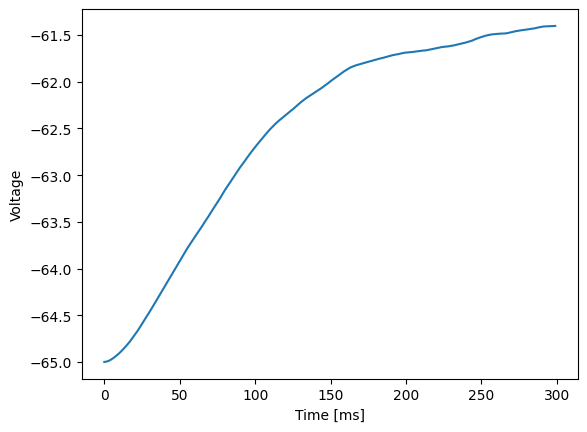

In [11]:
state = None
with torch.no_grad():
    volt = []
    output = []
    for t in range(TIME):
        z = x[t, :, :, :].view(-1, 28 * 28)
        z, state = lif(z, state)
        print(state)
        state = state._replace(z=torch.zeros_like(z))
        volt.append(state.v[0][0])
        # w = 0.1 * liner.weight / torch.sum(liner.weight, dim=1, keepdim=True)
        # liner.weight.data = w


fig, ax = plt.subplots()
ax.plot(volt)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Voltage")